## Image Retrieval

ref: https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


In [4]:
model = keras.applications.MobileNet(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("global_average_pooling2d_1").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [6]:
def get_image_list(images_path, max_num_images):
    """ Take the path where images are, return a list of filenames. 
    Where the images exceeded max_num_images, randomly sample from the folder.
    It returns a sorted list of filenames of length up to max_num_images."""

    image_list = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    len(image_list)

    # if dataset contain more than max_num_images, randomly sample from the folder
    if max_num_images < len(image_list):
        image_list = [image_list[i] for i in sorted(random.sample(xrange(len(image_list)), max_num_images))]

    print("%d images to be analyzed" % len(image_list))
    
    return sorted(image_list)


In [7]:
catalogue_images = get_image_list('/your/folder/catalogue', 1000)
mobile_images = get_image_list('/your/folder/mobile', 1000)

249 images to be analyzed
249 images to be analyzed


In [8]:
def extract_features(images):
    """ Take in a list of image file names, extract features, return a list of features, of type list of lists. """
    features = []
    for image_path in tqdm(images):
        img, x = get_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat) # this is of type list of lists
    return features

In [9]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [10]:
# extract features for catalogue images
features_catalogue = extract_features(catalogue_images)

# make sure all are processed
assert len(features_catalogue) == len(catalogue_images)
len(features_catalogue)
### Time taken on dlvm:
### 100%|██████████| 249/249 [00:06<00:00, 41.22it/s]

100%|██████████| 249/249 [00:05<00:00, 43.45it/s]


249

In [11]:
# extract features for segmented mobile images
features_mobile = extract_features(mobile_images)

# make sure all are processed
assert len(features_mobile) == len(mobile_images)
len(features_mobile)
### Time taken on dlvm:
### 100%|██████████| 249/249 [00:04<00:00, 51.38it/s]

100%|██████████| 249/249 [00:04<00:00, 50.99it/s]


249

### Display feature vectors

5.9869871

0.0

(249, 1024)

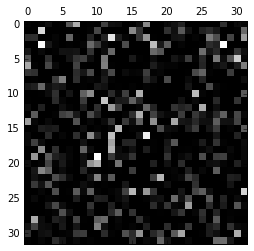

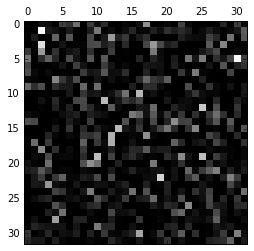

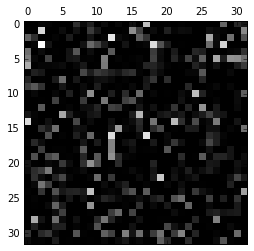

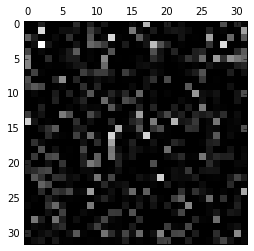

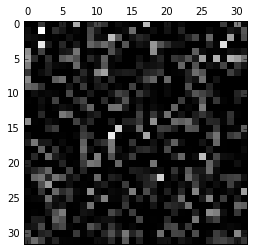

In [12]:
features_catalogue = np.array(features_catalogue)
features_catalogue.max()
features_catalogue.min()
features_catalogue.shape
# reshaping for the purpose of visualisation, otherwise length of 1024 is too long to be ploted in the notebook
# plt.matshow(feat, cmap='gray')
for i in range(5):
    _ = plt.matshow(np.reshape(features_catalogue[i],(32,32)), cmap='gray')
    

### Scale the features before apply PCA

In [13]:
from sklearn.preprocessing import MinMaxScaler

# convert list to np.array
features_catalogue = np.array(features_catalogue); features_catalogue.shape
features_catalogue.min()
features_catalogue.max()

# define a scaler 
scaler = MinMaxScaler()
scaler.fit(features_catalogue)

# scale the features
features_catalogue_scaled = scaler.transform(features_catalogue)
features_catalogue_scaled.min()
features_catalogue_scaled.max()

(249, 1024)

0.0

5.9869871

MinMaxScaler(copy=True, feature_range=(0, 1))

0.0

1.0000001

## Determine number of PCA components

- The maximum number of principal component is a minimum of (sample_size-1, variables). 

0.0

1.0000001

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

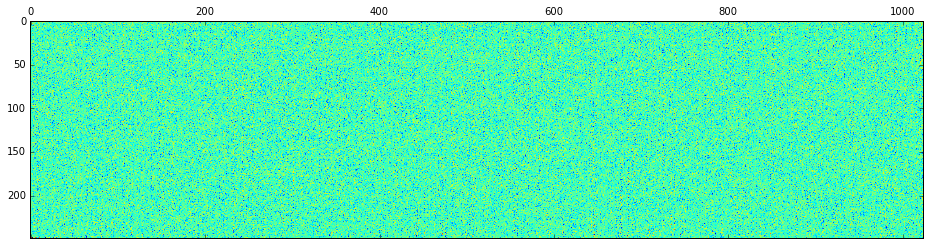

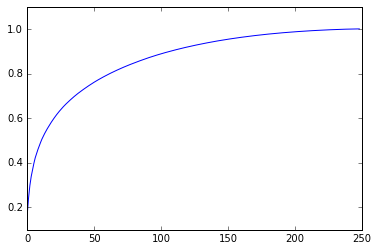

In [14]:
pca_catalogue = PCA(n_components=300)
features_catalogue_scaled.min()
features_catalogue_scaled.max()

pca_catalogue.fit(features_catalogue_scaled)

_ = plt.matshow(pca_catalogue.components_)
_ = plt.show()
_ = plt.plot(np.cumsum(pca_catalogue.explained_variance_ratio_))
_ = plt.show()

### Checking cumulative `explained_variance`

In [15]:
evar = np.cumsum(pca_catalogue.explained_variance_ratio_)

# get index where pca.explained_variance_ratio_ reached 0.99
np.min(np.ix_(evar >= 0.99))

207

### Repeat for features_mobile for curiosity

In [16]:
from sklearn.preprocessing import MinMaxScaler

# convert list to np.array
features_mobile = np.array(features_mobile); features_mobile.shape
features_mobile.min()
features_mobile.max()

# define a scaler 
scaler = MinMaxScaler()
scaler.fit(features_mobile)

# scale the features
features_mobile_scaled = scaler.transform(features_mobile)
features_mobile_scaled.min()
features_mobile_scaled.max()

(249, 1024)

0.0

5.9343672

MinMaxScaler(copy=True, feature_range=(0, 1))

0.0

1.0000001

0.0

1.0000001

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

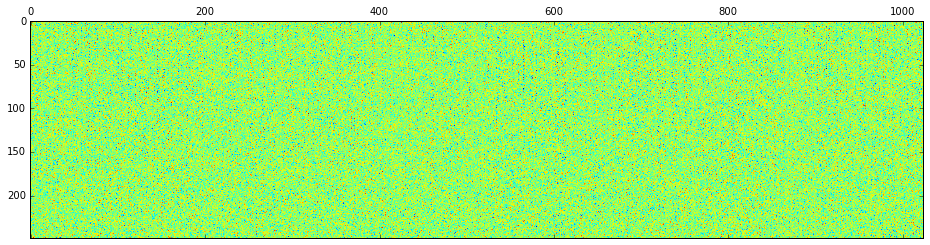

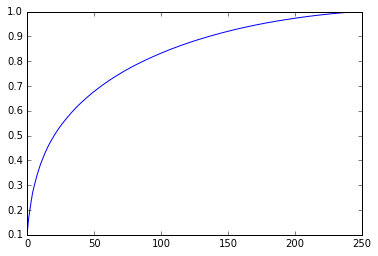

In [17]:
pca_mobile = PCA(n_components=300)
features_mobile_scaled.min()
features_mobile_scaled.max()

pca_mobile.fit(features_mobile_scaled)

_ = plt.matshow(pca_mobile.components_)
_ = plt.show()
_ = plt.plot(np.cumsum(pca_mobile.explained_variance_ratio_))
_ = plt.show()

In [18]:
evar = np.cumsum(pca_mobile.explained_variance_ratio_)

# get index where pca.explained_variance_ratio_ reached 0.99
np.min(np.ix_(evar >= 0.99))

225

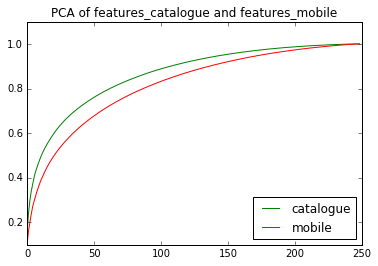

In [19]:
_ = plt.subplot(1,1,1)
_ = plt.plot(np.cumsum(pca_catalogue.explained_variance_ratio_), 'green', label='catalogue')
_ = plt.plot(np.cumsum(pca_mobile.explained_variance_ratio_), 'red', label='mobile')
_ = plt.title('PCA of features_catalogue and features_mobile')
_ = plt.legend(loc='lower right')

PCA components required to explain 99% of it's variance:
- `features_catalogue`: **207**
- `features_mobile`: **225** 

#### comparing with PCA on an unscaled feature vector

0.0

5.9869871

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

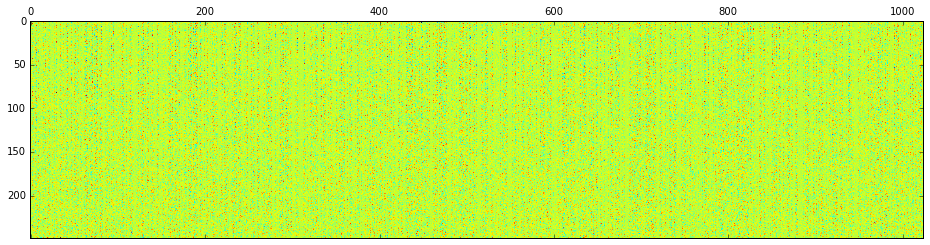

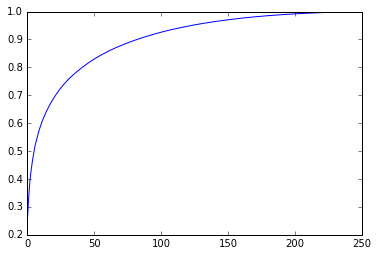

In [20]:
pca2 = PCA(n_components=300)
features_catalogue.min()
features_catalogue.max()

pca2.fit(features_catalogue)

_ = plt.matshow(pca2.components_)
_ = plt.show()
_ = plt.plot(np.cumsum(pca2.explained_variance_ratio_))
_ = plt.show()

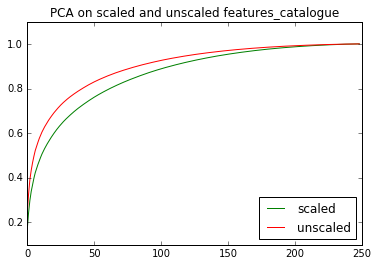

In [21]:
_ = plt.subplot(1,1,1)
_ = plt.plot(np.cumsum(pca_catalogue.explained_variance_ratio_), 'green', label='scaled')
_ = plt.plot(np.cumsum(pca2.explained_variance_ratio_), 'red', label='unscaled')
_ = plt.title('PCA on scaled and unscaled features_catalogue')
_ = plt.legend(loc='lower right')

### Create the final PCA using 207 components

In [22]:
pca_catalogue = PCA(n_components=207)
pca_catalogue.fit(features_catalogue_scaled)

#plt.matshow(pca_catalogue.components_)
#plt.show()
#plt.plot(np.cumsum(pca_catalogue.explained_variance_ratio_))
#plt.show()

PCA(copy=True, iterated_power='auto', n_components=207, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## Query images to PCA represenstation

- query images, i.e. segmented mobile images are then transformed into PCA representation before the distance is calculated.

In [23]:
# transform the catalogue images with PCA fit using catalogue images
pca_features_catalogue = pca_catalogue.transform(features_catalogue_scaled)
len(pca_features_catalogue)
pca_features_catalogue.shape

# transform the segmented mobile image with PCA fit using catalogue images
pca_features_mobile = pca_catalogue.transform(features_mobile_scaled)
len(pca_features_mobile)
pca_features_mobile.shape

249

(249, 207)

249

(249, 207)

In [24]:
def get_closest_images(query_image_idx, top_n=5):
    """ given a querry image index, i.e. segmented mobile image, return top_n closest match against pca_features_catalogue"""
    distances = [ distance.euclidean(pca_features_mobile[query_image_idx], feat) for feat in pca_features_catalogue ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:top_n+1]
    return idx_closest

def get_concatenated_images(images, indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Finally we can do a query on a randomly selected image in our dataset.

### Visualise the `top_n` closest match

The correct match is in position  6


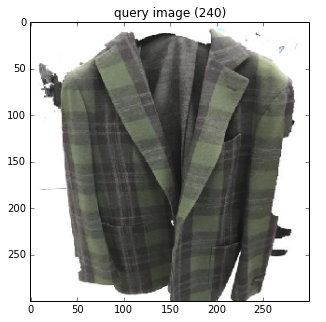

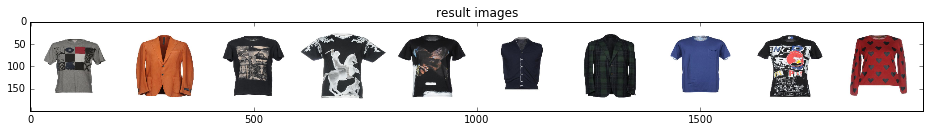

In [26]:
# get a random index
query_image_idx = int(len(mobile_images) * random.random())

# query on that random mobile image
idx_closest = get_closest_images(query_image_idx, top_n=10)

# print out the position of the correct match
for i, item in enumerate(idx_closest):
    if mobile_images[query_image_idx][-20:-10] in catalogue_images[item]:
        print('The correct match is in position ', i)
        
        query_image = get_concatenated_images(mobile_images,[query_image_idx], 300)
        results_image = get_concatenated_images(catalogue_images, idx_closest, 200)

        # display the query image
        _ = plt.figure(figsize = (5,5))
        _ = plt.imshow(query_image)
        _ = plt.title("query image (%d)" % query_image_idx)

        # display the resulting images
        _ = plt.figure(figsize = (16,12))
        _ = plt.imshow(results_image)
        _ = plt.title("result images")


### Evaluate for all the segmented images in the dataset

In [27]:
from collections import defaultdict

# Create a dict to store the indexes of top_n closest match for each query image
top_n_correct_matches_dict = defaultdict(dict)

for i, item in enumerate(mobile_images):
    # query on that mobile image
    idx_closest = get_closest_images(i, top_n=10); #idx_closest
    
    # save the indexes of top_n matches
    top_n_correct_matches_dict[mobile_images[i]] = idx_closest

# extract position of correct matched    
correct_matched_position = []

for item in top_n_correct_matches_dict: # for each mobile images
    #item
    for position, idx in enumerate(top_n_correct_matches_dict[item]): # i : indexes of top_n closest catalogue matches
        if item[-20:-10] in catalogue_images[idx]: # item[1][-20:-10] : '11111111xx'. If merchant id matches
            #print('The correct match is in position ', position, ' : ', catalogue_images[idx])
            correct_matched_position.append(position)
            
len(correct_matched_position)

61

In [28]:
# calculate cumulative accuracy
correct_match_percent = []
sum_of_correct_matched_position = []
cumsum_of_correct_matched_position = []

for topn in range(0,10):
    sum_of_correct_matched_position.append(sum(1 for item in correct_matched_position if item==topn))
sum_of_correct_matched_position

accuracy = np.cumsum(sum_of_correct_matched_position)/float(len(mobile_images))
accuracy

#import csv
#with open('./your/result.tsv', 'w') as f:
#    wr = csv.writer(f, delimiter='\t')
#    wr.writerow(accuracy)

[12, 9, 12, 5, 2, 4, 6, 4, 6, 1]

array([ 0.04819277,  0.08433735,  0.13253012,  0.15261044,  0.16064257,
        0.17670683,  0.20080321,  0.21686747,  0.24096386,  0.24497992])